# Feature Engineering 2

## Mean Encoding
- Category 데이터는 항상 One-hot Encoding만 해야하는 것은 아님.
- 다양한 인코딩 기법이 있음.
- 대표적인 방법으로 Y값에 대한 분포를 활용한 Mean Encoding이 사용됨.
- Label Encoding은 그 자체로 정보가 존재하지 않지만, Mean encoding은 분포의 값을 취할 수 있음.
- 조금 더 빨리, 조금 더 나은 성능이 나오기도 함.
- Regression Task(예측 문제)는 단순 평균값으로 입력함.
- Overfitting을 제거하기 위해 smoothing을 사용함.

- [Data_Preprocessing_4](https://github.com/yongchoooon/TIL/blob/main/ML/Data_Preprocessing/Data_Preprocessing_4.ipynb)의 titanic data 불러오기

In [15]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(style="white") # white background style for seaborn plots
sns.set(style="whitegrid", color_codes = True)

In [16]:
DATA_DIR = './titanic'
data_files = reversed([os.path.join(DATA_DIR, filename) for filename in os.listdir(DATA_DIR)])
df_list = []
for filename in data_files:
    df_list.append(pd.read_csv(filename))

df = pd.concat(df_list, sort=False) 
df = df.reset_index(drop=True) 

number_of_train_dataset = df.Survived.notnull().sum() 
number_of_test_dataset = df.Survived.isnull().sum() 
y_true = df.pop("Survived")[:number_of_train_dataset] 

object_columns = ["PassengerId", "Pclass", "Name", "Sex", "Ticket", "Cabin", "Embarked"]
numeric_columns = ["Age", "SibSp", "Parch", "Fare"]

# 데이터 타입 변경
for col_name in object_columns:
    df[col_name] = df[col_name].astype(object)

for col_name in numeric_columns:
    df[col_name] = df[col_name].astype(float)
    
df["Parch"] = df["Parch"].astype(int)
df["SibSp"] = df["SibSp"].astype(int)

df.loc[61, "Embarked"] = "S"
df.loc[829, "Embarked"] = "S"

# df 2개를 inner로 merge해주는 함수
def merge_and_get(ldf, rdf, on, how="inner", index = None):
    if index is True:
        return pd.merge(ldf, rdf, how = how, left_index = True, right_index = True)
    else:
        return pd.merge(ldf, rdf, how = how, on = on)

one_hot_df = merge_and_get(df, pd.get_dummies(df["Sex"], prefix = "Sex"), on = None, index = True) # sex_modified
one_hot_df = merge_and_get(one_hot_df, pd.get_dummies(df["Pclass"], prefix = "Pclass"), on = None, index = True)
one_hot_df = merge_and_get(one_hot_df, pd.get_dummies(df["Embarked"], prefix = "Embarked"), on = None, index = True)
one_hot_df.head(2)

c:\Miniconda3\envs\da\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,1,0,0,1,0,0


- Mean Encoding

In [17]:
temp_df = pd.merge(
    one_hot_df["Pclass"], y_true, left_index = True, right_index = True)
temp_df.groupby("Pclass")["Survived"].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [18]:
temp_df["Pclass"].replace(
    temp_df.groupby("Pclass")["Survived"].mean())

0      0.242363
1      0.629630
2      0.242363
3      0.629630
4      0.242363
         ...   
886    0.472826
887    0.629630
888    0.242363
889    0.629630
890    0.242363
Name: Pclass, Length: 891, dtype: float64

In [19]:
temp_columns = ["Sex", "Pclass", "Embarked"]

me_list = []
for col_name in temp_columns:
    temp_df = pd.merge(one_hot_df[col_name], y_true, left_index = True, right_index = True)
    temp_df["me_"+col_name] = temp_df[col_name].replace(temp_df.groupby(col_name)["Survived"].mean())
    me_list.append(temp_df.drop("Survived", axis = 1))
    # sns.countplot(x = col_name, hue = "Survived", data = temp_df)
    # plt.show()
    # sns.countplot(x = "me_" + col_name, hue = "Survived", data = temp_df)
    # plt.show()
me_list[2]


,Embarked,me_Embarked
0,S,0.339009
1,C,0.553571
2,S,0.339009
3,S,0.339009
4,S,0.339009
...,...,...
886,S,0.339009
887,S,0.339009
888,S,0.339009
889,C,0.553571


- Mean Encoding을 하면 Suvived와의 상관계수가 0.54, 0.34, 0.17로, 하지 않았을 때에 비해 높아졌다.
- 따라서 Mean Encoding을 하면 데이터를 더 잘 설명할 수 있다.

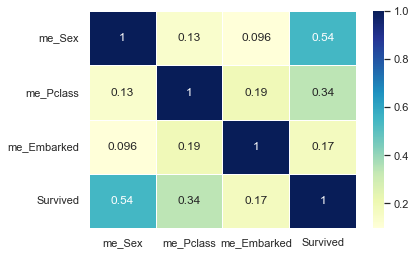

In [20]:
temp_df = pd.merge(
    pd.concat(me_list, axis = 1)[["me_" + col_name for col_name in temp_columns]],
    y_true, left_index = True, right_index = True)
# temp_df

corr = temp_df.corr()
sns.set()
ax = sns.heatmap(corr, annot = True, linewidths = 0.5, cmap = "YlGnBu")

- 이외에도 많은 Encoding 기법들이 존재함

## Interaction feature
- 기존 feature들의 조합으로 새로운 feature를 생성
- Data에 대한 사전 지식과 이해가 필요
- Polynomial feature를 사용한 자동화 가능 
    - `sklearn.preprocessing.PolynomialFeatures`
    - 높은 비용
- 실험적으로 접근할 요소들은 있음
    - 자동화 코드 만들면 됨.
- ex) weight, time-period, sensor1 + sensor2

- Categorical Combination
    - Sex와 Pclass, Embarked와 Pclass를 combination

In [22]:
temp_columns = ["Sex", "Pclass", "Embarked"]
one_hot_df["Sex-Pclass"] = df["Sex"].map(str) + df["Pclass"].map(str)
one_hot_df["Embarked-Pclass"] = df["Embarked"].map(str) + df["Pclass"].map(str)
one_hot_df = merge_and_get(one_hot_df, pd.get_dummies(one_hot_df["Sex-Pclass"], prefix = "SexPclass"), on = None, index = True)
one_hot_df = merge_and_get(one_hot_df, pd.get_dummies(one_hot_df["Embarked-Pclass"], prefix = "EmbarkedPclass"), on = None, index = True)
one_hot_df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SexPclass_male3,EmbarkedPclass_C1,EmbarkedPclass_C2,EmbarkedPclass_C3,EmbarkedPclass_Q1,EmbarkedPclass_Q2,EmbarkedPclass_Q3,EmbarkedPclass_S1,EmbarkedPclass_S2,EmbarkedPclass_S3
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,...,1,0,0,0,0,0,0,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,...,0,1,0,0,0,0,0,0,0,0


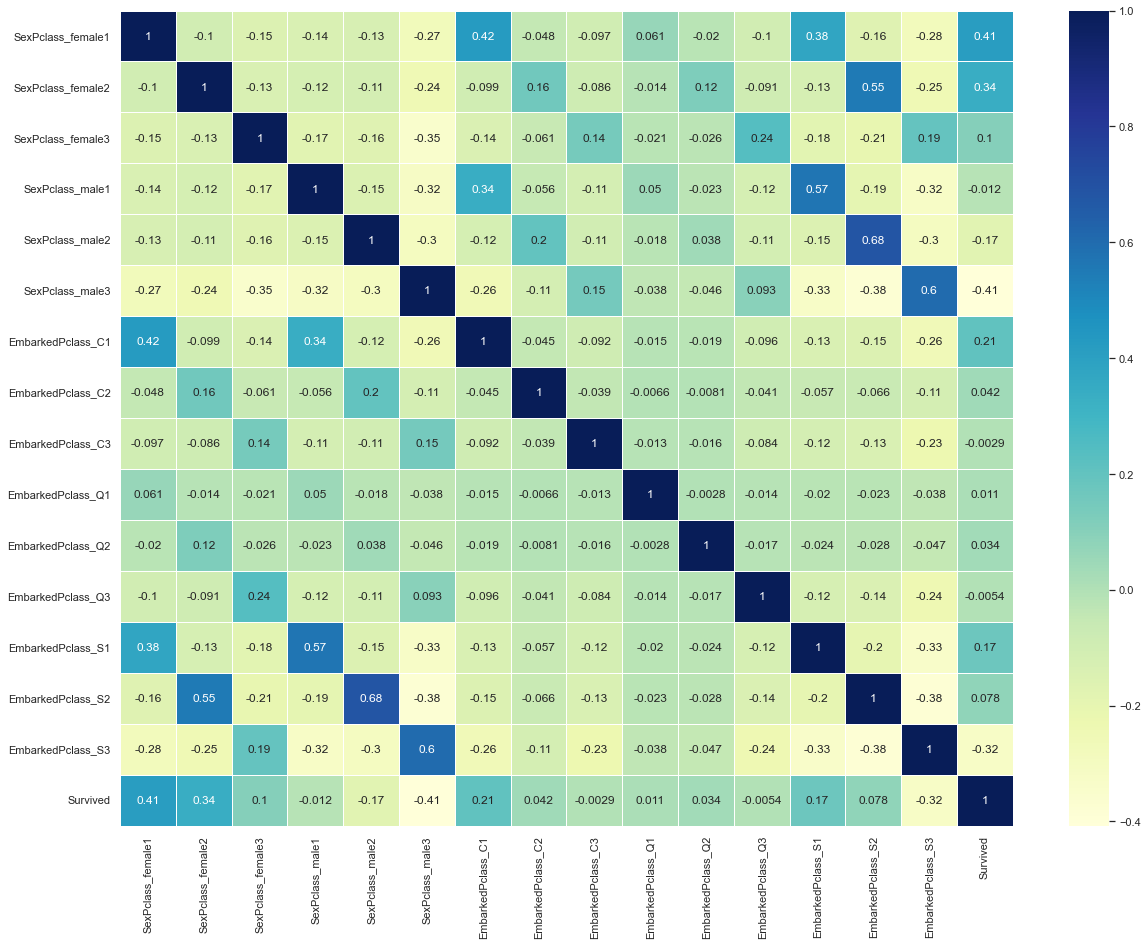

In [26]:
crosscheck_columns = [col_name for col_name in one_hot_df.columns.tolist()
                      if col_name.split("_")[0] in ["SexPclass", "EmbarkedPclass"] and "_" in col_name]
temp_df = pd.merge(one_hot_df[crosscheck_columns], y_true, left_index = True, right_index = True)

corr = temp_df.corr()
plt.subplots(figsize = (20, 15))
ax = sns.heatmap(corr, annot = True, linewidths = 0.5, cmap = "YlGnBu")

- 맨 아랫줄만 보면, 성별이 여자이고 Pclass가 1이면 상관계수가 0.41로 살 확률이 높고, 성별이 여자인데도 Pclass가 3이면 상관계수가 0.1로 살 확률이 적다.
- Embarked가 동일하게 C라 하더라고 Pclass가 1일 때 0.21로 살 확률이 높고, Pclass가 3이면 -0.0029로, 죽을 확률이 적게 존재한다. 

## Etc
- Feature끼리 더하기, 곱하기, 나누기 등등
- 왜 잘 되는지 모르는데 잘 되는 경우가 있음
- 도메인 지식과 EDA로 좋은 Feature들을 생성